# input the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, LeakyReLU
from keras.layers.noise import AlphaDropout
# from keras.optimizers import Adam

from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical

# load dataset

In [2]:
df = np.load("ORL_faces.npz")

In [3]:
# load train_test_data
x_train = df['trainX']
y_train = df['trainY']
x_test = df['testX']
y_test = df['testY']

In [4]:
#normalize each image 0-255 pixels
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

print('Training dataset shape: ',x_train.shape)
print('Testing dataset shape: ',x_test.shape)

Training dataset shape:  (240, 10304)
Testing dataset shape:  (160, 10304)


# split dataset

In [5]:
x_train,x_valid,y_train,y_valid= train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [6]:
print(x_train.shape,y_train.shape,x_valid.shape,y_valid.shape)

(216, 10304) (216,) (24, 10304) (24,)


# Transform the images to equal sizes to feed in CNN 

In [7]:
# Shape of image definition
rows = 112
columns = 92
image_shape = (rows,columns,1)

In [8]:
# Reshape function
x_train = x_train.reshape(x_train.shape[0],*image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
x_valid = x_valid.reshape(x_valid.shape[0],*image_shape)

In [9]:
print("traning dataset modified shape: ",x_train.shape)
print("testing dataset modified shape: ",x_test.shape)
print("validaing dataset modified shape: ",x_valid.shape)

traning dataset modified shape:  (216, 112, 92, 1)
testing dataset modified shape:  (160, 112, 92, 1)
validaing dataset modified shape:  (24, 112, 92, 1)


# Visualize images in different colormap

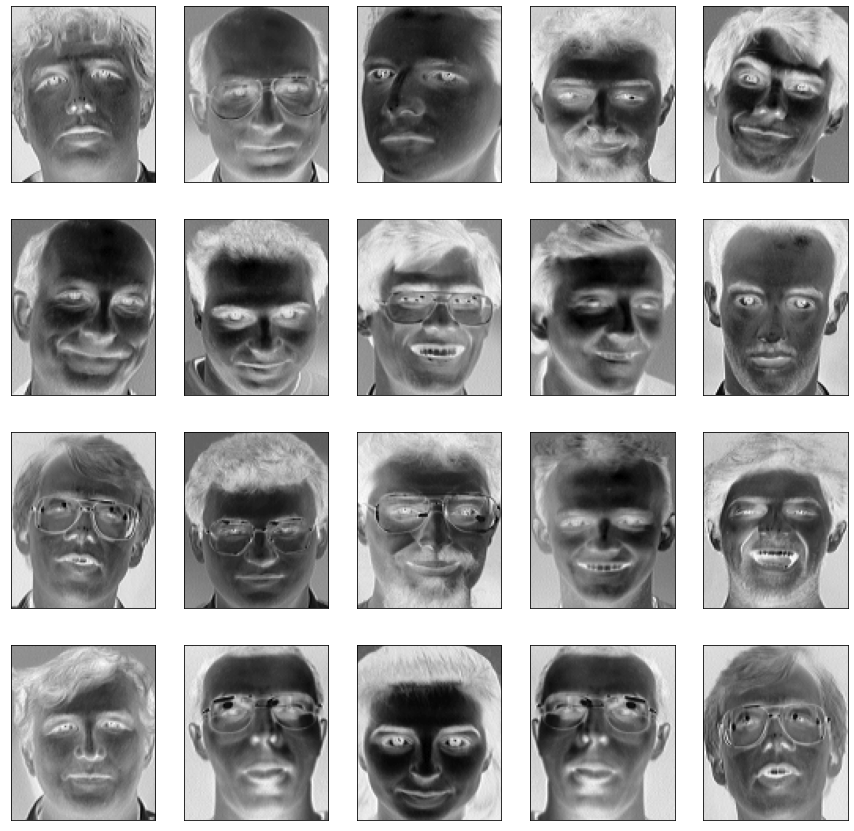

In [22]:
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary) # for gray scale
plt.show()

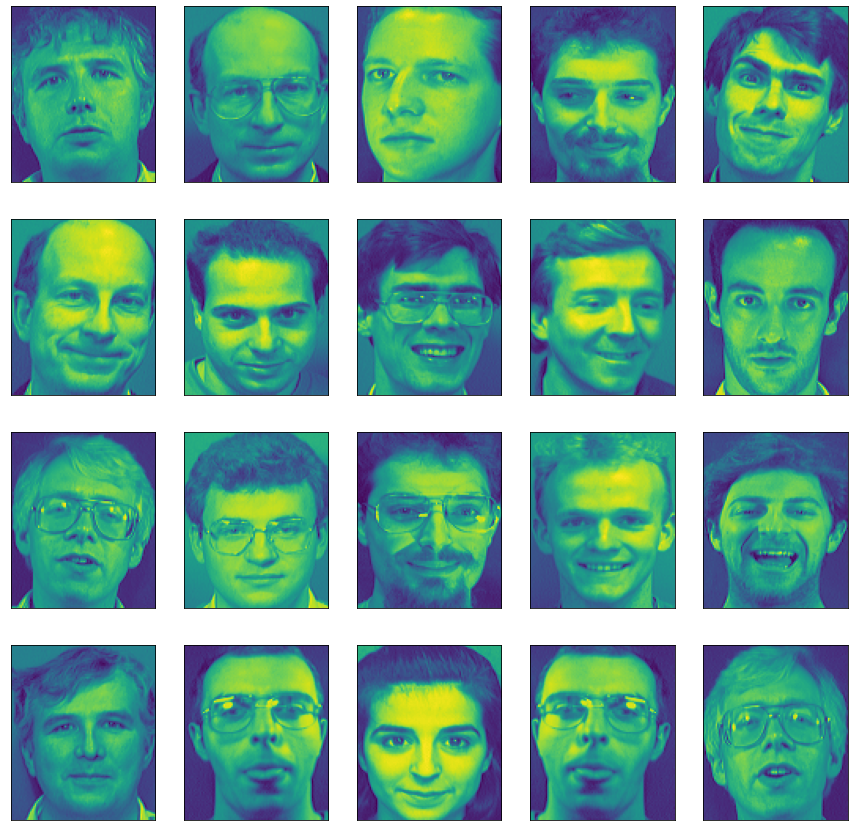

In [23]:
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i]) # for gray default
plt.show()

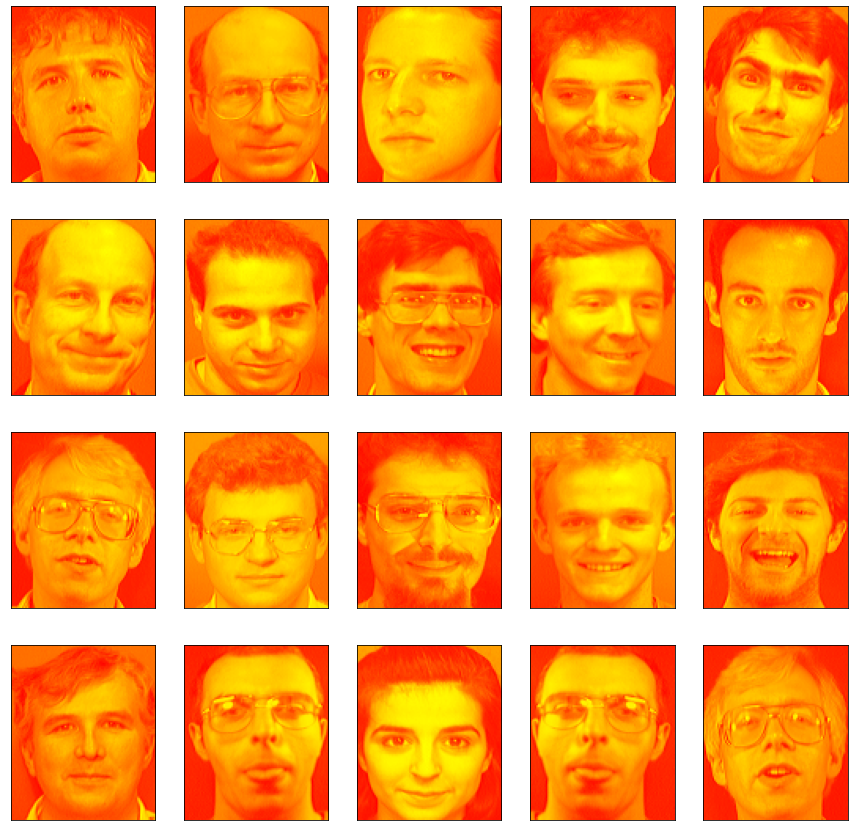

In [24]:
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.autumn) # for gray scale
plt.show()

# Build a CNN model that has 3 main layers:

# i. Convolutional Layer
# ii. Pooling Layer
# iii. Fully Connected Layer



In [13]:
# We will initialize our cnn model with activation function, dropout rate, optimizer
def cnn_model(activation,
              dropout_rate,
              optimizer):
    
    model = Sequential() #initialize Sequential model
    
    #we created if else version for program to 'selu' version or otheractivation functions
    
    if(activation == 'selu'):
        model.add(Conv2D(32, kernel_size=3,
                  activation=activation,
                  input_shape=image_shape,
                  kernel_initializer='lecun_normal')) #32 filter with kernel size of 3 with input shape
        model.add(MaxPooling2D(pool_size=2))
        
        model.add(Conv2D(64, 3, activation=activation, 
                         kernel_initializer='lecun_normal')) #64 filter with kernel size of 3 x 3
        model.add(MaxPooling2D(pool_size=2)) #Max pool with size of 2
        
        model.add(Flatten()) 
        model.add(Dense(2024, activation=activation, 
                        kernel_initializer='lecun_normal'))
        model.add(AlphaDropout(0.5))
        
        model.add(Dense(1024, activation=activation, 
                        kernel_initializer='lecun_normal'))
        model.add(AlphaDropout(0.5))
        
        model.add(Dense(512, activation=activation, 
                        kernel_initializer='lecun_normal'))
        model.add(AlphaDropout(0.5))
        
        model.add(Dense(20, activation='softmax')) #Output layer
    else:
        model.add(Conv2D(32, kernel_size=3,
                  activation=activation,
                  input_shape=image_shape)) #32 filter with kernel size of 3 x 3 with input shape
        model.add(MaxPooling2D(pool_size=2)) 
        
        model.add(Conv2D(64,3, activation=activation)) #64 filter with kernel size of 3 x 3
        model.add(MaxPooling2D(pool_size=2)) #Max pool with size of 2
        
        model.add(Flatten())
        
        model.add(Dense(2024, activation=activation))
        model.add(Dropout(0.5))
        model.add(Dense(1024, activation=activation))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation=activation))
        model.add(Dropout(0.5))
        
        model.add(Dense(20, activation='softmax')) #Output layer
    
    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer=optimizer, 
        metrics=['accuracy']
    ) #compile model with loss, optimizer chosen and accuracy as metrics
    
    return model

In [14]:
#For Leaky-Rely function we need to define aplha parameters using get_custom_objects

get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))}) 

# Defining the type of activation functions to be tested
activation_function = ['relu', 'elu', 'leaky-relu', 'selu']

# building model and train all chosen functions

In [15]:
from tensorflow.keras.optimizers import Adam

In [16]:
activation_results = [] #creating an empty matrix for storing results for activations

for activation in activation_function:
    print('\nTraining with {0} activation function\n'.format(activation))
    
    model = cnn_model(activation=activation,
                      dropout_rate=0.2,
                      optimizer=Adam(clipvalue=0.5)) #using 'adam' optimizer with clipvalue of 0.5
    
    history = model.fit(np.array(x_train), np.array(y_train), 
                        batch_size=512,
                        epochs=75, 
                        verbose=2,
                        validation_data=(np.array(x_valid),np.array(y_valid)))
    
    activation_results.append(history) #store results
    
    K.clear_session()
    del model

print(activation_results)


Training with relu activation function

Epoch 1/75
1/1 - 5s - loss: 2.9986 - accuracy: 0.0648 - val_loss: 3.1421 - val_accuracy: 0.0000e+00 - 5s/epoch - 5s/step
Epoch 2/75
1/1 - 2s - loss: 3.4464 - accuracy: 0.0787 - val_loss: 3.1351 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 3/75
1/1 - 2s - loss: 3.4415 - accuracy: 0.0509 - val_loss: 3.0381 - val_accuracy: 0.0833 - 2s/epoch - 2s/step
Epoch 4/75
1/1 - 2s - loss: 3.1256 - accuracy: 0.0787 - val_loss: 3.0051 - val_accuracy: 0.0833 - 2s/epoch - 2s/step
Epoch 5/75
1/1 - 2s - loss: 3.0464 - accuracy: 0.0509 - val_loss: 2.9982 - val_accuracy: 0.0833 - 2s/epoch - 2s/step
Epoch 6/75
1/1 - 2s - loss: 2.9850 - accuracy: 0.0602 - val_loss: 2.9992 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 7/75
1/1 - 2s - loss: 2.9900 - accuracy: 0.0694 - val_loss: 2.9886 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 8/75
1/1 - 2s - loss: 2.9484 - accuracy: 0.1528 - val_loss: 2.9819 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epo

Epoch 70/75
1/1 - 2s - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 71/75
1/1 - 2s - loss: 0.0106 - accuracy: 0.9954 - val_loss: 0.0040 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 72/75
1/1 - 2s - loss: 0.0204 - accuracy: 0.9907 - val_loss: 0.0033 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 73/75
1/1 - 2s - loss: 0.0099 - accuracy: 0.9954 - val_loss: 0.0031 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 74/75
1/1 - 2s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 75/75
1/1 - 2s - loss: 0.0073 - accuracy: 0.9954 - val_loss: 0.0034 - val_accuracy: 1.0000 - 2s/epoch - 2s/step

Training with elu activation function

Epoch 1/75
1/1 - 4s - loss: 3.1650 - accuracy: 0.0556 - val_loss: 4.9306 - val_accuracy: 0.0000e+00 - 4s/epoch - 4s/step
Epoch 2/75
1/1 - 3s - loss: 8.2237 - accuracy: 0.0417 - val_loss: 5.6917 - val_accuracy: 0.1250 - 3s/epoch - 3s/step
Epoch 3/75
1/1

1/1 - 2s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0103 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 65/75
1/1 - 2s - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 66/75
1/1 - 2s - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 67/75
1/1 - 2s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 68/75
1/1 - 2s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 69/75
1/1 - 2s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 70/75
1/1 - 2s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 71/75
1/1 - 2s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0145 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 72/75
1/1 - 2s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0

Epoch 59/75
1/1 - 3s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 60/75
1/1 - 3s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 61/75
1/1 - 5s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 - 5s/epoch - 5s/step
Epoch 62/75
1/1 - 5s - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000 - 5s/epoch - 5s/step
Epoch 63/75
1/1 - 4s - loss: 8.4765e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000 - 4s/epoch - 4s/step
Epoch 64/75
1/1 - 4s - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000 - 4s/epoch - 4s/step
Epoch 65/75
1/1 - 3s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 66/75
1/1 - 3s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 67/75
1/1 - 5s - loss: 0.0046 - accuracy: 1.00

Epoch 53/75
1/1 - 3s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 2.3254e-05 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 54/75
1/1 - 3s - loss: 0.0202 - accuracy: 1.0000 - val_loss: 3.4769e-08 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 55/75
1/1 - 2s - loss: 0.0214 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 56/75
1/1 - 3s - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 57/75
1/1 - 3s - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 3s/epoch - 3s/step
Epoch 58/75
1/1 - 2s - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 59/75
1/1 - 2s - loss: 0.0154 - accuracy: 0.9954 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 60/75
1/1 - 2s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 61/75
1/1 - 3s - l

In [17]:
# Lets try to plot the Model accuracy and Model loss for each activation function used above
# Just to make sure, we don't change the above data, so we store it in new matrix

activation_list = activation_function[0:]
results_new = activation_results[0:]

def plot_results(activation_results,activation_functions_new =[]):
    
    plt.figure(figsize=(8,6))
    
    # Model accuracy values plot
    for activation_function in activation_results:
        plt.plot(activation_function.history['val_accuracy'])
    
    plt.title('Model accuracy')
    plt.ylabel('Test Accuracy')
    plt.xlabel('No. of Epochs')
    plt.legend(activation_functions_new)
    plt.grid()
    plt.show()
    
    # Model loss values plot
    
    plt.figure(figsize=(8,6))
    
    for activation_function in activation_results:
        plt.plot(activation_function.history['val_loss'])
    
    plt.title('Model Loss')
    plt.ylabel('Test Loss')
    plt.xlabel('No. of Epochs')
    plt.legend(activation_functions_new)
    plt.grid()
    plt.show()

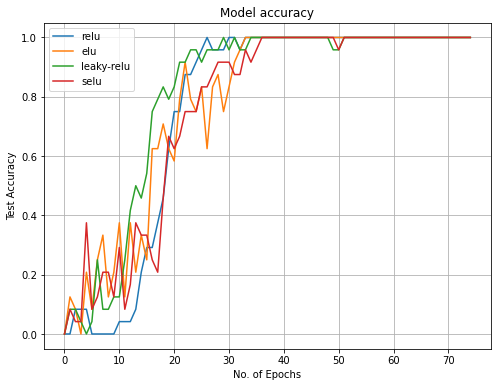

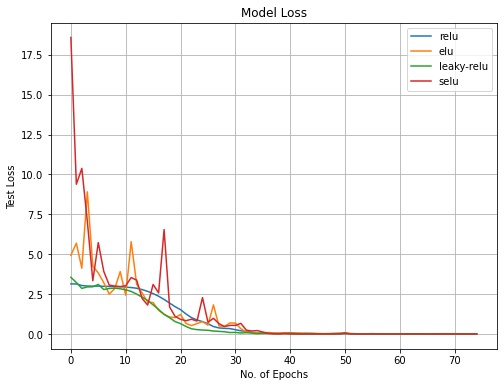

In [18]:
plot_results(results_new, activation_list)

In [19]:
activation_func_final ='leaky-relu'

model_final = cnn_model(activation=activation_func_final,
                    dropout_rate=0.2,
                    optimizer=Adam(clipvalue=0.5)) #using 'adam' optimizer with clipvalue of 0.5

history_final = model_final.fit(np.array(x_train), np.array(y_train), 
                    batch_size=512,
                    epochs=75, 
                    verbose=2,
                    validation_data=(np.array(x_valid),np.array(y_valid)))

Epoch 1/75
1/1 - 5s - loss: 2.9960 - accuracy: 0.0741 - val_loss: 3.5315 - val_accuracy: 0.0417 - 5s/epoch - 5s/step
Epoch 2/75
1/1 - 3s - loss: 5.0337 - accuracy: 0.0509 - val_loss: 3.6373 - val_accuracy: 0.0417 - 3s/epoch - 3s/step
Epoch 3/75
1/1 - 3s - loss: 4.7782 - accuracy: 0.0787 - val_loss: 2.8588 - val_accuracy: 0.1250 - 3s/epoch - 3s/step
Epoch 4/75
1/1 - 3s - loss: 3.4995 - accuracy: 0.0787 - val_loss: 2.9730 - val_accuracy: 0.0417 - 3s/epoch - 3s/step
Epoch 5/75
1/1 - 3s - loss: 2.9971 - accuracy: 0.1204 - val_loss: 2.9427 - val_accuracy: 0.0417 - 3s/epoch - 3s/step
Epoch 6/75
1/1 - 3s - loss: 2.9035 - accuracy: 0.1343 - val_loss: 2.9939 - val_accuracy: 0.1250 - 3s/epoch - 3s/step
Epoch 7/75
1/1 - 3s - loss: 3.3858 - accuracy: 0.1065 - val_loss: 2.8932 - val_accuracy: 0.1250 - 3s/epoch - 3s/step
Epoch 8/75
1/1 - 3s - loss: 2.9023 - accuracy: 0.1296 - val_loss: 2.8979 - val_accuracy: 0.1667 - 3s/epoch - 3s/step
Epoch 9/75
1/1 - 3s - loss: 2.8394 - accuracy: 0.1296 - val_loss

Epoch 71/75
1/1 - 2s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 72/75
1/1 - 2s - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 73/75
1/1 - 2s - loss: 6.0160e-04 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 74/75
1/1 - 2s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000 - 2s/epoch - 2s/step
Epoch 75/75
1/1 - 2s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000 - 2s/epoch - 2s/step


In [20]:
result_score = model_final.evaluate(np.array(x_test),np.array(y_test),verbose=0)

print('Test Loss {:.4f}'.format(result_score[0]))
print('Test Accuracy {:.4f}'.format(result_score[1]))

Test Loss 0.2931
Test Accuracy 0.9500


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


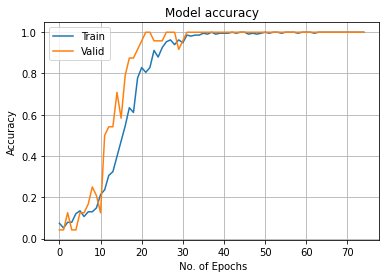

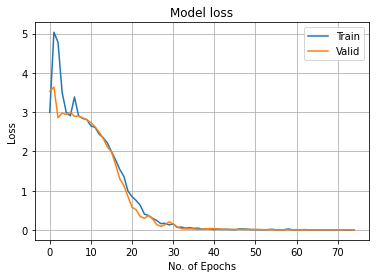

In [21]:
# Data in history

print(history_final.history.keys())

# Plotting Accuracy for final model
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel(' No. of Epochs')
plt.legend(['Train', 'Valid'])
plt.grid()
plt.show()

# Plotting Loss for Final Model
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['Train', 'Valid'])
plt.grid()
plt.show()

# Conclusion
 
 The model traninig is done by x_train & y_train with validation data as x_valid & y_valid. for evaluating model ,we use x_test & y_test which give us  loss 0.2077 with an accuracy of 95.63 %